In [1]:
# %%
import tensorflow as tf
import sys
sys.path.append("..")
import pandas as pd
import os
from utils import plot_history
from helper import brain_tumor_model, get_data_generators
import opendatasets as od

PROJECT_URL = "https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
BATCH_SIZE = 64
IMG_SHAPE = (456,456,3)

od.download(PROJECT_URL, "../datasets")

2023-05-13 10:40:23.005736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 10:40:24.247636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/local/cuda/extras/CUPTI/lib64
2023-05-13 10:40:24.247715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/usr/loca

Skipping, found downloaded files in "../datasets/brain-tumor-mri-images-44c" (use force=True to force download)


In [2]:
# Load the data
files = []
classes = []
for c in os.listdir(DATA_PATH):
    for f in os.listdir(os.path.join(DATA_PATH, c)):
        classes.append(c)
        files.append(os.path.join(DATA_PATH, c, f))

metadata = pd.DataFrame({"filepath":files, "tumor":classes})
# Create the data generators
num_classes = len(os.listdir(DATA_PATH))

train_gen, valid_gen, test_gen = get_data_generators(metadata, IMG_SHAPE[:-1], BATCH_SIZE)

Found 3582 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.


/home/olaf/.cache/pypoetry/virtualenvs/tensorflow-Wx5oGBw6-py3.10/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


2023-05-13 10:40:31.458145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 10:40:31.475388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 10:40:31.475605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 10:40:31.476095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/15


2023-05-13 10:40:45.520271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-05-13 10:40:45.910803: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-13 10:40:46.874831: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-13 10:40:46.879684: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-13 10:40:50.240949: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbc4abce6f0 initialized for platform CUDA 

20/56 [=========>....................] - ETA: 44s - loss: 44.0691 - accuracy: 0.2531

2023-05-13 10:41:14.711994: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-13 10:41:14.712032: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


56/56 [==============================] - 92s 1s/step - loss: 33.3594 - accuracy: 0.4034 - val_loss: 20.9889 - val_accuracy: 0.5067
Epoch 2/15
56/56 [==============================] - 74s 1s/step - loss: 14.0186 - accuracy: 0.6404 - val_loss: 10.3828 - val_accuracy: 0.6049
Epoch 3/15
56/56 [==============================] - 79s 1s/step - loss: 6.8862 - accuracy: 0.6985 - val_loss: 6.0270 - val_accuracy: 0.6518
Epoch 4/15
56/56 [==============================] - 72s 1s/step - loss: 4.0191 - accuracy: 0.7284 - val_loss: 4.1359 - val_accuracy: 0.6875
Epoch 5/15
56/56 [==============================] - 72s 1s/step - loss: 2.8506 - accuracy: 0.7426 - val_loss: 3.2082 - val_accuracy: 0.6942
Epoch 6/15
56/56 [==============================] - 72s 1s/step - loss: 2.3613 - accuracy: 0.7577 - val_loss: 2.7248 - val_accuracy: 0.7188
Epoch 7/15
56/56 [==============================] - 72s 1s/step - loss: 2.1412 - accuracy: 0.7638 - val_loss: 2.4337 - val_accuracy: 0.7098
Epoch 8/15
56/56 [=========

<Figure size 1400x1000 with 0 Axes>

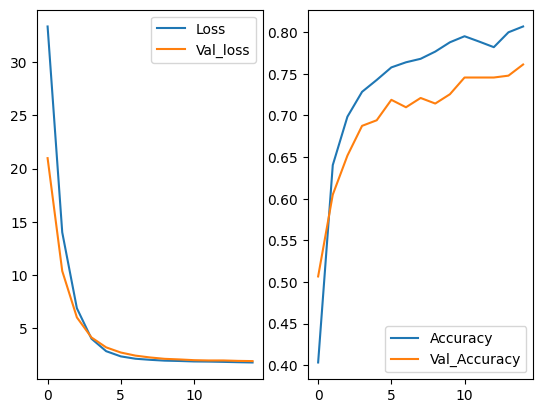

In [3]:
# Model
model = brain_tumor_model(IMG_SHAPE, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(train_gen, epochs=15, validation_data=valid_gen)

plot_history((history.history["loss"],
              history.history["val_loss"],
              history.history["accuracy"],
              history.history["val_accuracy"]))

Epoch 15/30
56/56 [==============================] - 78s 1s/step - loss: 1.6122 - accuracy: 0.8470 - val_loss: 1.7403 - val_accuracy: 0.7835
Epoch 16/30
56/56 [==============================] - 68s 1s/step - loss: 1.5077 - accuracy: 0.8733 - val_loss: 1.6918 - val_accuracy: 0.7879
Epoch 17/30
56/56 [==============================] - 68s 1s/step - loss: 1.4679 - accuracy: 0.8763 - val_loss: 1.6687 - val_accuracy: 0.7812
Epoch 18/30
56/56 [==============================] - 71s 1s/step - loss: 1.4422 - accuracy: 0.8850 - val_loss: 1.6396 - val_accuracy: 0.7946
Epoch 19/30
56/56 [==============================] - 70s 1s/step - loss: 1.4306 - accuracy: 0.8875 - val_loss: 1.6260 - val_accuracy: 0.7969
Epoch 20/30
56/56 [==============================] - 69s 1s/step - loss: 1.4028 - accuracy: 0.8836 - val_loss: 1.6093 - val_accuracy: 0.7946
Epoch 21/30
56/56 [==============================] - 71s 1s/step - loss: 1.3961 - accuracy: 0.8881 - val_loss: 1.5958 - val_accuracy: 0.7924
Epoch 22/30
5

<Figure size 1400x1000 with 0 Axes>

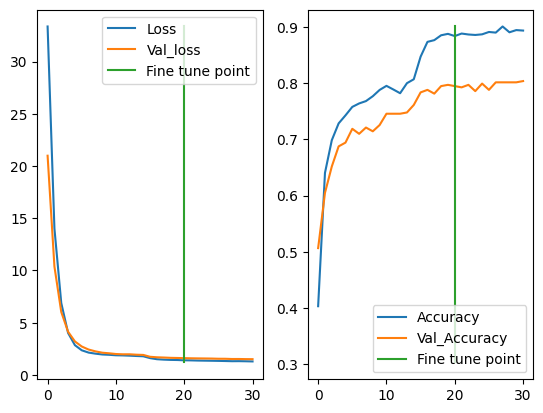

In [4]:
# fine tuning
for layer in model.layers[2].layers[int(len(model.layers[2].layers)*0.7):]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.00015),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history2 = model.fit(train_gen, epochs=30, initial_epoch=history.epoch[-1], validation_data=valid_gen)

plot_history((history.history["loss"] + history2.history["loss"],
              history.history["val_loss"] + history2.history["val_loss"],
              history.history["accuracy"] + history2.history["accuracy"],
              history.history["val_accuracy"] + history2.history["val_accuracy"]),
              20)